In [ ]:
import import_ipynb
import common_notebook
import numpy as np
import pandas as pd
from umap import UMAP
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown, Latex
from scipy.stats import normaltest, ttest_rel
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

In [ ]:
# Imports from common_notebook
process = common_notebook.process
get_data = common_notebook.get_data
mean = common_notebook.mean
std = common_notebook.std
as_dict = common_notebook.as_dict
METRIC_COLUMNS = common_notebook.METRIC_COLUMNS
MAINTAINABILITY_COLUMNS = common_notebook.MAINTAINABILITY_COLUMNS

In [ ]:
def plt_save_and_display(image_name):
    plt.savefig('./analysis/' + image_name + '.png', bbox_inches='tight')
    plt.close()
    display(Markdown('![' + image_name + '](./analysis/' + image_name + '.png)'))

# Dataset

In [ ]:
df = get_data()

In [ ]:
# Show unbalance on the dataset
df['target'] = df[MAINTAINABILITY_COLUMNS].idxmax(axis=1).apply(lambda x: MAINTAINABILITY_COLUMNS.index(x))
data_balance = df.groupby(['projectname','target']).count()[['path']].rename(columns={"path": "count"})
array_balance = data_balance.unstack(level=1).astype("Int64")
array_balance

count              
target              0   1   2     3
projectname                        
aoi                10  20  25    18
argoUML            34  25  11     4
diarymanagement     7   2   2  <NA>
jsweet             63   5   2     3
junit4             60  12   1  <NA>

# Metrics mutual information with targets

In [ ]:
df = get_data()

In [ ]:
df['target'] = ((df[MAINTAINABILITY_COLUMNS[0]] + df[MAINTAINABILITY_COLUMNS[1]])
                > (df[MAINTAINABILITY_COLUMNS[2]] + df[MAINTAINABILITY_COLUMNS[3]]))
binary_metrics = common_notebook.sort_metrics(df)
binary_metrics_index = pd.DataFrame({'binary': range(1, 34)}, index=binary_metrics.index)

In [ ]:
df['target'] = df[MAINTAINABILITY_COLUMNS].idxmax(axis=1).apply(lambda x: MAINTAINABILITY_COLUMNS.index(x))
multi_metrics = common_notebook.sort_metrics(df)
multi_metrics_index = pd.DataFrame({'multi': range(1, 34)}, index=multi_metrics.index)

In [ ]:
df['target'] = df[MAINTAINABILITY_COLUMNS].values.tolist()
proba_metrics = common_notebook.sort_metrics_probabilities(df)
proba_metrics_index = pd.DataFrame({'proba': range(1, 34)}, index=proba_metrics.index)

In [ ]:
df['target'] = (0 * df[MAINTAINABILITY_COLUMNS[0]]
                + 1 * df[MAINTAINABILITY_COLUMNS[1]]
                + 2 * df[MAINTAINABILITY_COLUMNS[2]]
                + 3 * df[MAINTAINABILITY_COLUMNS[3]])
continuous_metrics = common_notebook.sort_metrics_continuous(df)
continuous_metrics_index = pd.DataFrame({'continuous': range(1, 34)}, index=continuous_metrics.index)

In [ ]:
sorted_metrics = continuous_metrics_index.join(proba_metrics_index).join(multi_metrics_index).join(binary_metrics_index)
sorted_metrics

continuous  proba  multi  binary
non_am                 1      3     16      18
nos_am                 2      2     19      21
non                    3      1      1       2
nos_lm                 4      4      6       6
mnd                    5      5     22      15
nle                    6      6     24      19
cgc                    7      7      7       7
cyc                    8      8      8       8
lpc                    9     12     23      20
non_m                 10      9      2       1
nos                   11     11      3       4
nos_m                 12     10      4       3
cbod                  13     18     26      24
non_lm                14     13      5       5
rfc_ic                15     16      9      12
noi_ic                16     21     14      17
rfc                   17     14     10      11
mpc                   18     19     12      13
noi                   19     20     15      14
nolm                  20     15     17      23
nlam                  21     17     18      22
mll                   22     22     13      10
cbo                   23     23     20      25
dac                   24     24     11       9
nos_deeper_4          25     25     21      16
nom                   26     26     25      26
lcom4                 27     27     28      28
noa                   28     28     29      29
nop                   29     29     33      33
dit                   30     30     32      31
nod                   31     32     30      30
noc                   32     33     31      32
cboi                  33     31     27      27

# Statistical hypothesis tests on binary separation

In [ ]:
class BestBinaryClassifier:
    estimator = "LogisticRegression"
    parameters = "{'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}"
    metrics = 18
    preprocessing = "Standardization"
    oversampling = False

In [ ]:
class BaselocClassifier:
    estimator = "BinaryBaselocClassifier"
    parameters = "{}"
    metrics = 1
    preprocessing = None
    oversampling = False

In [ ]:
df = common_notebook.get_data()
df['target'] = ((df[MAINTAINABILITY_COLUMNS[0]] + df[MAINTAINABILITY_COLUMNS[1]])
                > (df[MAINTAINABILITY_COLUMNS[2]] + df[MAINTAINABILITY_COLUMNS[3]]))
df['fold'] = df['target']
sorted_metrics = common_notebook.sort_metrics(df)
scoring = {'f-score': 'f1'}

In [ ]:
best_scores = process(BestBinaryClassifier, df, sorted_metrics, scoring, common_notebook.FoldType.K_FOLD)['f-score']
base_scores = process(BaselocClassifier, df, sorted_metrics, scoring, common_notebook.FoldType.K_FOLD)['f-score']

In [ ]:
stat, p = normaltest(best_scores)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably Gaussian')
else:
 print('Probably not Gaussian')

stat=0.209, p=0.901
Probably Gaussian


In [ ]:
stat, p = normaltest(base_scores)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably Gaussian')
else:
 print('Probably not Gaussian')

stat=0.123, p=0.941
Probably Gaussian


In [ ]:
stat, p = ttest_rel(best_scores, base_scores)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
 print('Probably the same distribution')
else:
 print('Probably different distributions')

stat=6.429, p=0.000
Probably different distributions


# Metrics and Continuous Maintainability

In [ ]:
# Prepare data frame for the rest of the analysis
df = get_data()
df['target'] = (0 * df[MAINTAINABILITY_COLUMNS[0]]
                + 1 * df[MAINTAINABILITY_COLUMNS[1]]
                + 2 * df[MAINTAINABILITY_COLUMNS[2]]
                + 3 * df[MAINTAINABILITY_COLUMNS[3]])
df['fold'] = np.around(df['target'] * 2).astype(int)
df.sort_values(by='target', ascending=True, inplace=True)

## Correlation heat-map

In [ ]:
METRIC_COLUMNS_ORDERED_BY_TYPE = [
    'non', 'nos', 'non_m', 'nos_m', 'non_am', 'nos_am', 'non_lm', 'nos_lm', 'mll', 'nos_deeper_4',
    'cyc', 'cgc', 'lpc', 'mnd', 'nle',
    'cbod', 'cboi', 'cbo', 'dac',
    'mpc', 'noi', 'noi_ic', 'rfc', 'rfc_ic',
    'nop', 'noa', 'noc', 'nod', 'dit', 'nolm', 'nlam', 'nom',
    'lcom4']

In [ ]:
df['maintainability'] = df['target']
corr = df[METRIC_COLUMNS_ORDERED_BY_TYPE + ['maintainability']].corr("kendall")

# Generate the annotation
annot = corr.round(1).astype('string')

f, ax = plt.subplots(figsize=(20, 20))
cmap = sns.color_palette("rocket_r", as_cmap=True)
mask = np.triu(np.ones_like(corr), )
ax = sns.heatmap(corr, cmap=cmap, vmax=1, vmin=0,
                 square=True, linewidths=.5, cbar_kws={"shrink": .5},
                 annot=annot, fmt="", mask=mask) # .1f
plt_save_and_display('correlation-heatmap')

![correlation-heatmap](./analysis/correlation-heatmap.png)

## Maintainability by size

In [ ]:
x_name = "Size of the Class (nos)"
y_name = "Continuous Maintainability"
hue_name = "Project"

plt.figure(figsize=(8,6))
ax = sns.scatterplot(
    data=df.query("nos<2000").rename(columns={"nos": x_name, "target": y_name, "projectname": hue_name}),
    x=x_name,
    y=y_name,
    hue=hue_name,
    style=hue_name)
ax.axhline(y=1.5, color='b', linewidth=0.5, linestyle='dotted')
ax.axvline(x=275, color='b', linewidth=0.5, linestyle='dotted')
plt_save_and_display('maintainability-by-size')

![maintainability-by-size](./analysis/maintainability-by-size.png)

In [ ]:
data = [[len(df.query('nos < 275 and target > 1.5')),len(df.query('nos > 275 and target > 1.5'))],
        [len(df.query('nos < 275 and target < 1.5')),len(df.query('nos > 275 and target < 1.5'))]]

pd.DataFrame(data, index=['Maintainability > 1.5','Maintainability < 1.5'], columns=['nos < 275','nos > 275'])

nos < 275  nos > 275
Maintainability > 1.5         19         47
Maintainability < 1.5        231          7

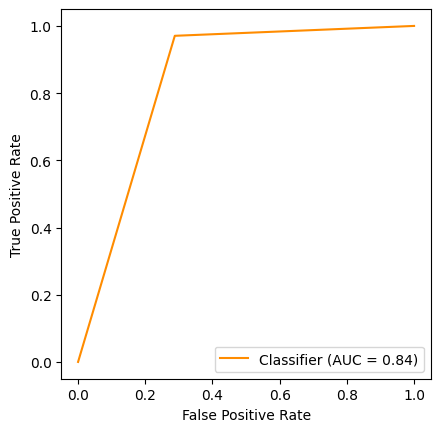

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

df['binary_target'] = ((df[MAINTAINABILITY_COLUMNS[0]] + df[MAINTAINABILITY_COLUMNS[1]])
                       > (df[MAINTAINABILITY_COLUMNS[2]] + df[MAINTAINABILITY_COLUMNS[3]]))
RocCurveDisplay.from_predictions(
    df['binary_target'].values,
    (df['nos']<275).values,
    color='darkorange',
)
df.drop(columns='binary_target', inplace=True)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Metrics by size (nos)

In [ ]:
data = df[list(continuous_metrics_index.index) + ['fold']]
data.insert(0, 'nos_', df['nos'])
data = data.melt(id_vars=['nos_','fold'], var_name='metric', value_name='value')

g = sns.relplot(data=data, x='nos_', y='value', hue='fold',
                col='metric', col_wrap=5, height=2.5, legend=False, facet_kws=dict(sharey=False))
g.set(xlabel=None, xscale="log", xticklabels=[])
g.set(ylabel=None, yscale="log", yticklabels=[])
g.figure.subplots_adjust(wspace=.05, hspace=.2)
plt_save_and_display('metrics-by-size')

![metrics-by-size](./analysis/metrics-by-size.png)

## Metrics by fold

In [ ]:
data = df[list(continuous_metrics_index.index) + ['fold']]
data = data.melt(id_vars=['fold'], var_name='metric', value_name='value')
    
g = sns.catplot(data=data, x='fold', y='value', hue='fold', jitter=0.3,
                col='metric', col_wrap=5, height=2.5, legend=False, sharey=False)
g.set(xlabel=None, xticklabels=[])
g.set(ylabel=None, yscale='log', yticklabels=[])
g.figure.subplots_adjust(wspace=.05, hspace=.2)
plt_save_and_display('metrics-by-fold')

![metrics-by-fold](./analysis/metrics-by-fold.png)

## Dimensionality analysis

In [ ]:
data = df[METRIC_COLUMNS]
data = StandardScaler().fit_transform(data)
pca = PCA(n_components=8)
pca.fit(data)

print(np.around(pca.explained_variance_ratio_, 2))

pd.DataFrame(pca.explained_variance_ratio_, index=pca.get_feature_names_out())
pd.DataFrame(pca.components_, columns=METRIC_COLUMNS, index=pca.get_feature_names_out())

[0.47 0.16 0.07 0.07 0.04 0.04 0.03 0.02]


nos    non  non_m  nos_m  non_am  nos_am  non_lm  nos_lm    mll  \
pca0  0.227  0.205  0.234  0.226   0.187   0.196   0.213   0.223  0.156   
pca1 -0.105 -0.094 -0.094 -0.107   0.034  -0.047  -0.019  -0.093 -0.146   
pca2  0.043 -0.002  0.008  0.045  -0.202  -0.180  -0.129  -0.080 -0.088   
pca3  0.038 -0.051 -0.022  0.043  -0.279  -0.243  -0.204  -0.114 -0.213   
pca4  0.127  0.078  0.084  0.126  -0.276  -0.255  -0.232  -0.199  0.010   
pca5 -0.070 -0.137 -0.088 -0.063  -0.009  -0.007   0.023   0.085 -0.323   
pca6  0.169  0.153  0.137  0.176  -0.124  -0.102  -0.096  -0.077 -0.053   
pca7  0.258  0.183  0.213  0.267   0.050   0.092   0.078   0.081 -0.376   

      nos_deeper_4    cbo   cbod   cboi    cgc    cyc    dac    dit  lcom4  \
pca0         0.168  0.131  0.156  0.044  0.216  0.235  0.191 -0.002  0.090   
pca1        -0.178  0.234  0.302  0.049 -0.167  0.039  0.180  0.159  0.384   
pca2        -0.027  0.299 -0.099  0.485 -0.007  0.021 -0.082 -0.210 -0.090   
pca3         0.152 -0.072 -0.004 -0.087 -0.046  0.028 -0.156  0.337 -0.053   
pca4        -0.195  0.128 -0.056  0.236  0.106  0.119  0.004 -0.179 -0.108   
pca5         0.281 -0.031  0.048 -0.087 -0.177 -0.051 -0.111 -0.323  0.099   
pca6        -0.018 -0.342 -0.097 -0.373  0.086  0.209 -0.169 -0.303  0.076   
pca7         0.103  0.040 -0.135  0.166  0.008  0.190 -0.308  0.219 -0.039   

        lpc    mnd    mpc  nlam    nle    noa    noc    nod    noi  noi_ic  \
pca0  0.168  0.185  0.207 0.162  0.174  0.010 -0.003 -0.002  0.198   0.198   
pca1 -0.099 -0.197 -0.141 0.318 -0.179  0.081  0.033  0.033 -0.146  -0.146   
pca2  0.055  0.005  0.110 0.007 -0.007 -0.127  0.477  0.464  0.084   0.084   
pca3 -0.103  0.132  0.238 0.007 -0.086  0.411 -0.045 -0.059  0.252   0.252   
pca4  0.273 -0.129  0.034 0.091  0.011 -0.148 -0.439 -0.441 -0.026  -0.023   
pca5 -0.334  0.185  0.132 0.035 -0.155 -0.409 -0.157 -0.126  0.181   0.178   
pca6 -0.101 -0.016 -0.088 0.151  0.049 -0.253  0.126  0.180 -0.172  -0.174   
pca7 -0.261 -0.042 -0.138 0.018 -0.072  0.255 -0.040 -0.000 -0.185  -0.191   

      nolm   nom    nop    rfc  rfc_ic  
pca0 0.163 0.149  0.011  0.224   0.224  
pca1 0.317 0.338  0.031  0.146   0.145  
pca2 0.006 0.008 -0.054  0.057   0.057  
pca3 0.005 0.014  0.360  0.163   0.164  
pca4 0.091 0.061 -0.113  0.026   0.028  
pca5 0.031 0.046 -0.313  0.142   0.140  
pca6 0.150 0.173  0.378  0.015   0.013  
pca7 0.014 0.027 -0.359 -0.094  -0.098

In [ ]:
mse = []
importances_mean = []
importances_std = []

for seed in common_notebook.SEEDS:
    X_train, X_test, y_train, y_test = train_test_split(df[METRIC_COLUMNS], df['target'], random_state=seed)
    forest = RandomForestRegressor(n_estimators= 100, max_depth=5, criterion='absolute_error', random_state=seed)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    mse.append(mean_squared_error(y_test, y_pred))
    result = permutation_importance(
        forest, X_test, y_test, n_repeats=10, n_jobs=2, scoring='neg_mean_squared_error'
    )
    importances_mean.append(result.importances_mean)
    importances_std.append(result.importances_std)
    

A SHAP analysis can also help: [Introduction to SHAP with Python](https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454)

In [ ]:
forest_importances = pd.DataFrame(columns=METRIC_COLUMNS, data=importances_mean)
order = forest_importances.mean().sort_values(ascending=False).index
ax = sns.barplot(data=forest_importances, errorbar="sd", order=order, palette='colorblind')
ax.tick_params(axis='x', labelrotation=90)
ax.set_yticks(np.arange(-0.01, 0.43, 0.01), minor=True)
ax.set_ylabel("Difference of MSE")
ax.grid(axis='y', which='both', linestyle='dotted')
ax.grid(axis='y', which='major', linestyle='-')
plt_save_and_display('permutation-analysis')

![permutation-analysis](./analysis/permutation-analysis.png)

In [ ]:
# https://pair-code.github.io/understanding-umap/
umap = UMAP(random_state=42)
embedding = umap.fit_transform(df[METRIC_COLUMNS])
embedding_df = pd.DataFrame(data=embedding, index=df.index, columns=["x", "y"])
embedding_df = embedding_df.join(df[METRIC_COLUMNS]).join(df[["fold"]])
sns.scatterplot(data=embedding_df, x="x", y="y", hue='fold')
plt_save_and_display('umap-embedding')

![umap-embedding](./analysis/umap-embedding.png)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

LABEL_COLUMNS = common_notebook.MAINTAINABILITY_COLUMNS

def linear_regression():
    scaler = StandardScaler(with_mean=False)
    X = scaler.fit_transform(df[METRIC_COLUMNS])
    regressor = LinearRegression()
    regressor.fit(X, df[LABEL_COLUMNS])
    prediction = regressor.predict(X)
    prediction_df = pd.DataFrame(
        data=prediction,
        columns=LABEL_COLUMNS,
        index=df.index)
    coefs = pd.DataFrame(
        data=regressor.coef_,
        columns=METRIC_COLUMNS,
        index=LABEL_COLUMNS)
    
    display(prediction_df)
    display(coefs)
    
linear_regression()

maintainable very high  \
artofillusion.animation.NullKeyframe                             0.887   
org.junit.validator.AnnotationValidator                          0.893   
junit.framework.AssertionFailedError                             0.921   
TBA.Data.User                                                    0.583   
org.junit.internal.builders.SuiteMethodBuilder                   0.755   
...                                                                ...   
artofillusion.SplineMeshEditorWindow                             0.068   
artofillusion.translators.OBJImporter                           -0.233   
org.argouml.model.mdr.CoreFactoryMDRImpl                         0.041   
artofillusion.raytracer.RTTriangleLowMemory                      0.026   
nik777.aoi.HelpPlugin                                           -0.051   

                                                maintainable high  \
artofillusion.animation.NullKeyframe                        0.169   
org.junit.validator.AnnotationValidator                     0.176   
junit.framework.AssertionFailedError                        0.153   
TBA.Data.User                                               0.268   
org.junit.internal.builders.SuiteMethodBuilder              0.220   
...                                                           ...   
artofillusion.SplineMeshEditorWindow                       -0.322   
artofillusion.translators.OBJImporter                       0.040   
org.argouml.model.mdr.CoreFactoryMDRImpl                   -0.073   
artofillusion.raytracer.RTTriangleLowMemory                 0.153   
nik777.aoi.HelpPlugin                                      -0.021   

                                                maintainable low  \
artofillusion.animation.NullKeyframe                      -0.050   
org.junit.validator.AnnotationValidator                   -0.058   
junit.framework.AssertionFailedError                      -0.040   
TBA.Data.User                                              0.133   
org.junit.internal.builders.SuiteMethodBuilder             0.039   
...                                                          ...   
artofillusion.SplineMeshEditorWindow                       0.142   
artofillusion.translators.OBJImporter                      0.222   
org.argouml.model.mdr.CoreFactoryMDRImpl                   0.258   
artofillusion.raytracer.RTTriangleLowMemory                0.529   
nik777.aoi.HelpPlugin                                      0.415   

                                                maintainable very low  
artofillusion.animation.NullKeyframe                           -0.007  
org.junit.validator.AnnotationValidator                        -0.011  
junit.framework.AssertionFailedError                           -0.033  
TBA.Data.User                                                   0.016  
org.junit.internal.builders.SuiteMethodBuilder                 -0.015  
...                                                               ...  
artofillusion.SplineMeshEditorWindow                            1.112  
artofillusion.translators.OBJImporter                           0.970  
org.argouml.model.mdr.CoreFactoryMDRImpl                        0.774  
artofillusion.raytracer.RTTriangleLowMemory                     0.291  
nik777.aoi.HelpPlugin                                           0.657  

[304 rows x 4 columns]

nos    non  non_m  nos_m  non_am  nos_am  non_lm  \
maintainable very high -0.415 -0.008 -0.360  0.767  -0.161  -0.001   0.143   
maintainable high      -0.039  0.031  0.052 -0.144   0.202  -0.104  -0.436   
maintainable low        0.066 -0.068  0.389 -0.516  -0.011   0.078   0.069   
maintainable very low   0.388  0.046 -0.081 -0.106  -0.029   0.027   0.224   

                        nos_lm    mll  nos_deeper_4    cbo   cbod   cboi  \
maintainable very high  -0.136 -0.002         0.212 -0.163 -0.018  0.148   
maintainable high        0.473 -0.083         0.018  1.049 -0.567 -0.821   
maintainable low        -0.108  0.034        -0.134 -0.892  0.601  0.683   
maintainable very low   -0.230  0.051        -0.096  0.006 -0.017 -0.010   

                          cgc    cyc    dac    dit  lcom4    lpc    mnd  \
maintainable very high  0.364 -0.320  0.083  0.050  0.111 -0.074 -0.155   
maintainable high      -0.345  0.166 -0.014 -0.043 -0.069  0.089 -0.160   
maintainable low       -0.162  0.310 -0.067 -0.017 -0.069 -0.001  0.216   
maintainable very low   0.143 -0.157 -0.002  0.010  0.026 -0.015  0.099   

                          mpc   nlam    nle    noa    noc    nod    noi  \
maintainable very high -0.002  1.067 -0.165 -0.039 -0.013  0.044 -0.196   
maintainable high       0.264 -4.112  0.186  0.024  0.013 -0.043  0.413   
maintainable low       -0.043  2.780  0.031  0.031  0.005 -0.005 -0.425   
maintainable very low  -0.219  0.265 -0.052 -0.016 -0.006  0.004  0.208   

                        noi_ic   nolm    nom    nop    rfc  rfc_ic  
maintainable very high   0.071 -1.192  0.119  0.007 -0.037   0.126  
maintainable high       -0.575  4.081  0.036 -0.009  0.277  -0.327  
maintainable low         0.560 -2.533 -0.186  0.007 -0.388   0.214  
maintainable very low   -0.056 -0.357  0.031 -0.006  0.149  -0.013

## Incremental addition of metrics

In [ ]:
metrics = ['nos', 'cgc', 'non_am', 'cbo', 'non', 'mnd', 'nom', 'cboi', 'nos_m', 'cyc', 'nolm',
           'mll', 'noi', 'nlam', 'dac', 'nos_am', 'nos_lm', 'nle', 'lpc', 'non_m', 'cbod',
           'non_lm', 'rfc_ic', 'noi_ic', 'rfc', 'mpc',
           'nos_deeper_4', 'lcom4', 'noa', 'nop', 'dit', 'nod', 'noc']

metrics_range = range(len(metrics))
ranked_metrics = pd.DataFrame({'rank': metrics_range}, index=metrics)

In [ ]:
class MetricsClassifier:
    estimator = "RandomForestRegressor"
    parameters = "{'n_estimators': 100, 'max_depth': 5, 'criterion': 'squared_error'}"
    metrics = 0
    preprocessing = "Standardization"
    oversampling = False

scoring = { 'mse': 'neg_mean_squared_error' }
increments = []
old_score = -1
for i in metrics_range:
    MetricsClassifier.metrics = i + 1
    scores = process(MetricsClassifier, df, ranked_metrics, scoring, common_notebook.FoldType.K_FOLD)['mse']
    mean_score = mean(scores)
    increments.append(mean_score)
    diff_score = np.around(mean_score - old_score, 4)
    print("{:>12}: {:.4f} ±{:.4f} -> diff: {:+.4f}".format(metrics[i], mean_score, std(scores), diff_score))
    old_score = mean_score

         nos: -0.2827 ±0.0585 -> diff: +0.7173
         cgc: -0.2138 ±0.0488 -> diff: +0.0689
      non_am: -0.1857 ±0.0465 -> diff: +0.0281
         cbo: -0.1730 ±0.0431 -> diff: +0.0127
         non: -0.1690 ±0.0431 -> diff: +0.0040
         mnd: -0.1671 ±0.0424 -> diff: +0.0019
         nom: -0.1641 ±0.0424 -> diff: +0.0030
        cboi: -0.1629 ±0.0421 -> diff: +0.0012
       nos_m: -0.1615 ±0.0424 -> diff: +0.0014
         cyc: -0.1621 ±0.0425 -> diff: -0.0006
        nolm: -0.1637 ±0.0427 -> diff: -0.0016
         mll: -0.1657 ±0.0422 -> diff: -0.0020
         noi: -0.1673 ±0.0427 -> diff: -0.0016
        nlam: -0.1673 ±0.0425 -> diff: +0.0000
         dac: -0.1683 ±0.0414 -> diff: -0.0010
      nos_am: -0.1721 ±0.0412 -> diff: -0.0038
      nos_lm: -0.1767 ±0.0427 -> diff: -0.0046
         nle: -0.1772 ±0.0431 -> diff: -0.0005
         lpc: -0.1777 ±0.0434 -> diff: -0.0005
       non_m: -0.1788 ±0.0432 -> diff: -0.0011
        cbod: -0.1796 ±0.0432 -> diff: -0.0008
      non_lm:

In [ ]:
ax = sns.lineplot(x=metrics_range, y=increments)
ax.set_ylabel("MSE")
plt_save_and_display('metrics-increments')

![metrics-increments](./analysis/metrics-increments.png)

Can be automated with a [SequentialFeatureSelector](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SequentialFeatureSelector.html) to be included in a [Pipeline](https://scikit-learn.org/stable/modules/feature_selection.html#feature-selection-as-part-of-a-pipeline).


# Results

In [ ]:
base_classifiers = ["AlwaysTrueClassifier", "BinaryBaselocClassifier", 
                   "AlwaysAClassifier", "ClassBaselocClassifier", 
                   "AlwaysMeanRegressor", "ContinuousBaselocRegressor"]

def load_results(problem, files, sk_metrics):
    
    results = []
    for file in files:
        for fold in ('project-wise', 'k-fold'):
            for metrics in ('all', 'loc', 'cgc'):
                r = pd.read_csv(file.format(fold=fold, metrics=metrics), dtype = {'metrics': pd.Int8Dtype()})
                r = r[~r["estimator"].isin(base_classifiers)]
                r.insert(0, 'problem', problem)
                r.insert(1, 'problem_fold', fold)
                r.insert(2, 'problem_metrics', metrics)
                results.append(r)
                
    result = pd.concat(results, ignore_index=True)
        
    for metric in sk_metrics:
        #result[metric] = list(zip(np.round(result[metric], 2), np.round(-result[metric + '-std'], 2)))
        result[metric] = list(zip(result[metric], -result[metric + '-std']))
        result.drop(columns=[metric + '-std'], inplace=True)
        
    return result

In [ ]:
def compare_sk_metrics(x):
    return max(x.apply(lambda x: (np.round(x[0],2), np.round(x[1],2))))

In [ ]:
binary_files = ['conf/1-{fold}-binary-separation-{metrics}.csv']
binary_metrics = ['f-score', 'auc', 'recall', 'precision']
binary_results = load_results('binary', binary_files, binary_metrics)
binary_results.groupby(['problem_fold', 'problem_metrics'])[binary_metrics].agg(compare_sk_metrics)

f-score            auc       recall  \
problem_fold problem_metrics                                              
k-fold       all              (0.96, -0.02)  (0.97, -0.02)  (1.0, -0.0)   
             cgc              (0.96, -0.02)  (0.95, -0.03)  (1.0, -0.0)   
             loc              (0.95, -0.02)  (0.95, -0.03)  (1.0, -0.0)   
project-wise all              (0.93, -0.05)    (0.9, -0.1)  (1.0, -0.0)   
             cgc              (0.94, -0.04)  (0.89, -0.11)  (1.0, -0.0)   
             loc               (0.9, -0.06)  (0.81, -0.24)  (1.0, -0.0)   

                                  precision  
problem_fold problem_metrics                 
k-fold       all              (0.95, -0.02)  
             cgc              (0.96, -0.02)  
             loc              (0.93, -0.03)  
project-wise all              (0.91, -0.07)  
             cgc              (0.92, -0.08)  
             loc               (0.88, -0.1)

In [ ]:
ordinal_files = ['conf/2-{fold}-multi-classification-{metrics}.csv', 'conf/3-{fold}-probabilities-regression-{metrics}.csv']
ordinal_metrics = ['acc', 'mse', 'ck', 'mcc']
ordinal_results = load_results('ordinal', ordinal_files, ordinal_metrics)
ordinal_results.loc[ordinal_results.preprocessing==' ', 'preprocessing'] = np.NaN
ordinal_results.groupby(['problem_fold', 'problem_metrics'])[ordinal_metrics].agg(compare_sk_metrics)

acc             mse             ck  \
problem_fold problem_metrics                                                 
k-fold       all              (0.77, -0.04)  (-0.27, -0.06)  (0.61, -0.07)   
             cgc              (0.75, -0.04)  (-0.31, -0.08)  (0.56, -0.07)   
             loc              (0.72, -0.04)  (-0.35, -0.08)  (0.52, -0.08)   
project-wise all              (0.74, -0.12)  (-0.39, -0.32)  (0.46, -0.17)   
             cgc              (0.73, -0.12)   (-0.4, -0.18)   (0.45, -0.1)   
             loc              (0.67, -0.17)  (-0.49, -0.29)  (0.38, -0.16)   

                                        mcc  
problem_fold problem_metrics                 
k-fold       all              (0.62, -0.09)  
             cgc              (0.57, -0.08)  
             loc              (0.53, -0.08)  
project-wise all              (0.48, -0.19)  
             cgc              (0.49, -0.11)  
             loc              (0.41, -0.16)

In [ ]:
continuous_files = ['conf/4-{fold}-continuous-maintainability-{metrics}.csv']
continuous_metrics = ['mean-error', 'mse', 'r2', 'median-error', 'ordinal-mse']
continuous_results = load_results('continuous', continuous_files, continuous_metrics)
continuous_results.groupby(['problem_fold', 'problem_metrics'])[continuous_metrics].agg(compare_sk_metrics)

mean-error             mse             r2  \
problem_fold problem_metrics                                                  
k-fold       all              (-0.26, -0.03)  (-0.18, -0.05)   (0.8, -0.05)   
             cgc               (-0.3, -0.04)  (-0.23, -0.07)  (0.75, -0.08)   
             loc              (-0.33, -0.04)  (-0.27, -0.06)   (0.7, -0.06)   
project-wise all              (-0.33, -0.14)  (-0.28, -0.22)  (0.41, -0.43)   
             cgc              (-0.38, -0.14)  (-0.32, -0.14)   (0.3, -0.37)   
             loc              (-0.43, -0.19)  (-0.42, -0.21)  (0.04, -0.53)   

                                median-error     ordinal-mse  
problem_fold problem_metrics                                  
k-fold       all               (-0.1, -0.04)  (-0.27, -0.06)  
             cgc              (-0.07, -0.04)  (-0.32, -0.08)  
             loc              (-0.11, -0.04)  (-0.36, -0.08)  
project-wise all              (-0.19, -0.12)  (-0.39, -0.27)  
             cgc              (-0.22, -0.22)  (-0.44, -0.22)  
             loc              (-0.22, -0.23)  (-0.52, -0.28)

## Analysis

In [ ]:
def plt_format(ax, x_min, x_max):
    ax.set_xlim([x_min, x_max])
    ax.set_axisbelow(True)
    ax.set_ylabel(None)
    ax.set_xlabel("Negative Mean Square Error")
    ax.set_xticks(np.arange(x_min, x_max, 0.01), minor=True)
    ax.set_yticks(ax.get_yticks(), ax.get_yticklabels(), rotation=45, ha='right')
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.grid(axis='x', which='both', linestyle='dotted')
    ax.grid(axis='x', which='major', linestyle='-')

In [ ]:
ordinal_continuous_results = continuous_results.copy()
ordinal_continuous_results['mse'] = ordinal_continuous_results['ordinal-mse']

data = pd.concat([ordinal_results, ordinal_continuous_results], ignore_index=True)
data = data[(data["problem_metrics"]=="all")]
data = data[~data['estimator'].str.contains('Always|Baseloc')]
data = data[data['problem_fold']=='k-fold']
data['mse'] = data['mse'].apply(lambda x: x[0])

meta = data['estimator'].str.contains('Chained|Decomposition|Proba|Rounded')
data.loc[meta, 'problem'] = 'meta-ordinal'
data.insert(3, 'problem-subset', data['problem'].str.title())
data.loc[meta, 'problem-subset'] = data['estimator'].str.replace('Classifier', '').str.replace('Regressor', '')
data.loc[meta, 'estimator'] = data['parameters'].map(lambda s: as_dict(s).get('estimator'))
data['estimator'] = data['estimator'].str.replace('Classifier', '')
data['estimator'] = data['estimator'].str.replace('Regressor', '')

data = data.drop(columns=['parameters','completed','error','problem_fold','problem_metrics',
                          'acc','ck','mcc','mean-error','r2','median-error','ordinal-mse'])

order = pd.DataFrame(data.groupby(['estimator'])['mse'].median()).sort_values(by='mse').index

In [ ]:
plt.figure(figsize=(8,7))
hue_order = pd.DataFrame(data.groupby(['problem'])['mse'].median()).sort_values(by='mse').index
ax = sns.boxplot(data=data, x="mse", y="estimator", hue="problem", palette="colorblind", order=order, hue_order=hue_order)
plt_format(ax, -0.8, -0.2)
plt_save_and_display('problem-comparison')

![problem-comparison](./analysis/problem-comparison.png)

In [ ]:
plt.figure(figsize=(8,10))
hue_order = pd.DataFrame(data.groupby(['problem-subset'])['mse'].median()).sort_values(by='mse').index
ax = sns.boxplot(data=data, x="mse", y="estimator", hue="problem-subset", palette="colorblind", order=order, hue_order=hue_order)
plt_format(ax, -0.8, -0.2)
plt_save_and_display('problem-subset-comparison')

![problem-subset-comparison](./analysis/problem-subset-comparison.png)

In [ ]:
data = continuous_results.copy()
data = data[~data['estimator'].str.contains('Always|Baseloc')]
data = data[data['problem_fold']=='k-fold']
data['mse'] = data['mse'].apply(lambda x: x[0])

plt.figure(figsize=(8,7))
order = pd.DataFrame(data.groupby(['estimator'])['mse'].median()).sort_values(by='mse').index
hue_order = pd.DataFrame(data.groupby(['problem_metrics'])['mse'].median()).sort_values(by='mse').index
ax = sns.boxplot(data=data, x="mse", y="estimator", hue="problem_metrics", palette="colorblind", order=order, hue_order=hue_order)
plt_format(ax, -0.6, -0.1)
plt_save_and_display('size-experiments-continuous')

![size-experiments-continuous](./analysis/size-experiments-continuous.png)

In [ ]:
data = ordinal_results.copy()
data = data[~data['estimator'].str.contains('Always|Baseloc')]
data = data[data['problem_fold']=='k-fold']
data['mse'] = data['mse'].apply(lambda x: x[0])

plt.figure(figsize=(8,7))
order = pd.DataFrame(data.groupby(['estimator'])['mse'].median()).sort_values(by='mse').index
hue_order = pd.DataFrame(data.groupby(['problem_metrics'])['mse'].median()).sort_values(by='mse').index
ax = sns.boxplot(data=data, x="mse", y="estimator", hue="problem_metrics", palette="colorblind", order=order, hue_order=hue_order)
plt_format(ax, -1.0, -0.1)
plt_save_and_display('size-experiments-ordinal')

![size-experiments-ordinal](./analysis/size-experiments-ordinal.png)

In [ ]:
data = binary_results.copy()
data = data[~data['estimator'].str.contains('Always|Baseloc')]
data = data[data['problem_fold']=='k-fold']
data['auc'] = data['auc'].apply(lambda x: x[0])

plt.figure(figsize=(8,7))
order = pd.DataFrame(data.groupby(['estimator'])['auc'].median()).sort_values(by='auc').index
hue_order = pd.DataFrame(data.groupby(['problem_metrics'])['auc'].median()).sort_values(by='auc').index
ax = sns.boxplot(data=data, x="auc", y="estimator", hue="problem_metrics", palette="colorblind", order=order, hue_order=hue_order)
plt_format(ax, 0.7, 1)
ax.set_xlabel("Area Under the Receiver Operating Characteristic Curve")
plt_save_and_display('size-experiments-binary')

![size-experiments-binary](./analysis/size-experiments-binary.png)

In [ ]:
data = continuous_results.copy()
data = data[~data['estimator'].str.contains('Always|Baseloc')]
data = data[data['problem_fold']=='k-fold']
data = data[data['problem_metrics']=='all']
data['mse'] = data['mse'].apply(lambda x: x[0])

plt.figure(figsize=(8,7))
order = pd.DataFrame(data.groupby(['estimator'])['mse'].median()).sort_values(by='mse').index
hue_order = ['5', '10', '18', '25', '33']
data['metrics'] = data['metrics'].astype(str)
ax = sns.boxplot(data=data, x="mse", y="estimator", hue="metrics", palette="colorblind", order=order, hue_order=hue_order)
plt_format(ax, -0.6, -0.1)
plt_save_and_display('metrics-comparison')

![metrics-comparison](./analysis/metrics-comparison.png)

In [ ]:
data = continuous_results.copy()
data = data[~data['estimator'].str.contains('Always|Baseloc')]
data = data[data['problem_fold']=='k-fold']
data = data[data['problem_metrics']=='all']
data['mse'] = data['mse'].apply(lambda x: x[0])
data.fillna(value={"preprocessing": "None"}, inplace=True)

plt.figure(figsize=(8,7))
order = pd.DataFrame(data.groupby(['estimator'])['mse'].median()).sort_values(by='mse').index
hue_order = pd.DataFrame(data.groupby(['preprocessing'])['mse'].median()).sort_values(by='mse').index
data['metrics'] = data['metrics'].astype(str)
ax = sns.boxplot(data=data, x="mse", y="estimator", hue="preprocessing", palette="colorblind", order=order, hue_order=hue_order)
plt_format(ax, -0.6, -0.1)
plt_save_and_display('preprocessing-comparison')

![preprocessing-comparison](./analysis/preprocessing-comparison.png)